In [29]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tarfile

In [12]:
my_tar = tarfile.open('images.tgz')
my_tar.extractall('/content/') # specify which folder to extract to
my_tar.close()

## Dataset

First let's load in the data. We will use keras ImageDataGenerator to not only label the data from the directories but also to slightly augment the data with shifts, rotations, zooms, and mirroring. *Mirroring* will help to ensure that the data are not biased to a particular handedness.

In [30]:
train_dir = "images/train/"
val_dir = "images/val/"

In [31]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [32]:
N_BATCH = 128
TARGET_SIZE = (224,224)

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 10.,
                                   width_shift_range=0.1,
                                   height_shift_range=0,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale = 1./255)

train_gen = train_datagen.flow_from_directory(train_dir,
                                              target_size = TARGET_SIZE,
                                              color_mode = 'grayscale',
                                              batch_size = N_BATCH,
                                              classes = ['NONE','ONE','TWO','THREE','FOUR','FIVE'],
                                              class_mode = 'categorical',
                                              shuffle = True)

val_gen = val_datagen.flow_from_directory(val_dir,
                                          target_size = TARGET_SIZE,
                                          color_mode = 'grayscale',
                                          batch_size = N_BATCH,
                                          classes = ['NONE','ONE','TWO','THREE','FOUR','FIVE'],
                                          class_mode ='categorical',
                                          shuffle = False)

Found 9081 images belonging to 6 classes.
Found 3632 images belonging to 6 classes.


To not have any bias towards any particular label, lets check how many instances (number of images) each classes have.

Text(0.5, 1.0, 'Blue --> Training data\nRed --> Validation data')

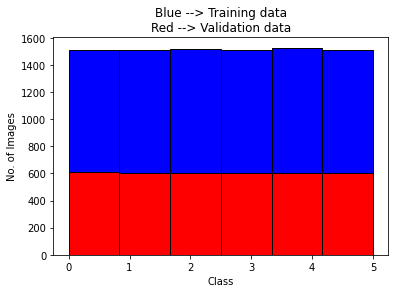

In [33]:
plt.hist(train_gen.classes,color='blue',bins=6,edgecolor='black')
plt.hist(val_gen.classes,color='red',bins=6,edgecolor='black')
plt.xlabel('Class')
plt.ylabel('No. of Images')
plt.title("Blue --> Training data\n"
          "Red --> Validation data")

This shows that we have balanced dataset!!

Next we'll do some quick checks to make sure our data are labeled correctly

In [34]:
# double check things aren't mixed up
train_gen.class_indices == val_gen.class_indices

True

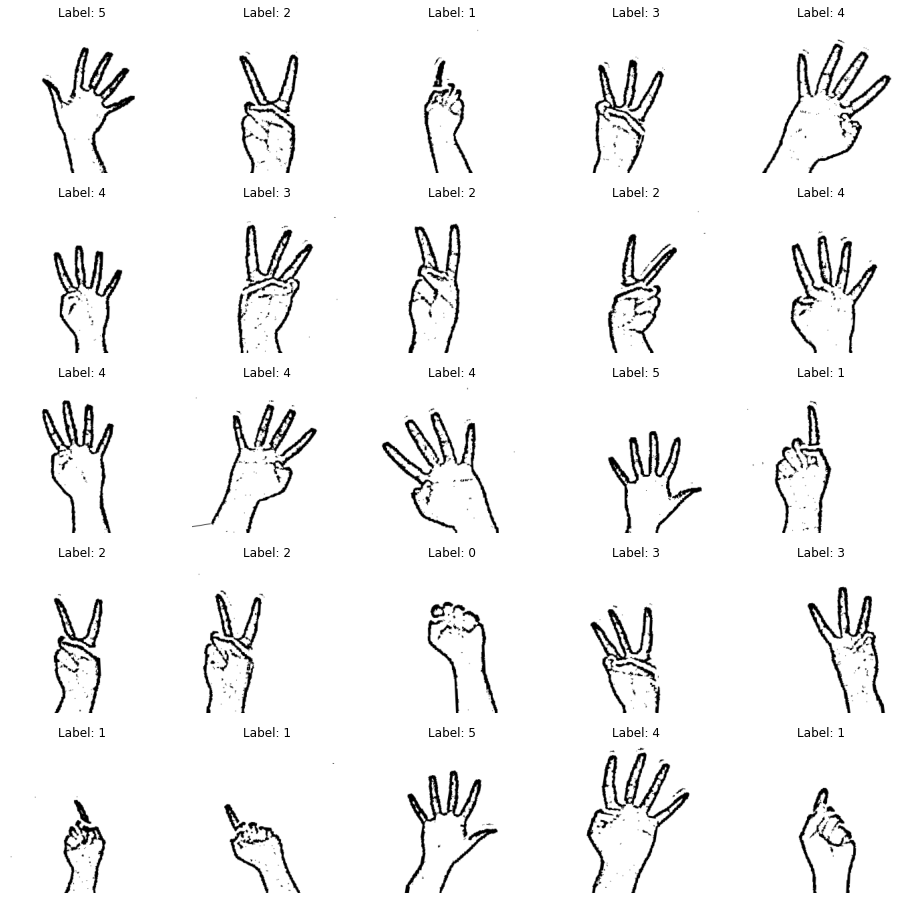

In [35]:
for X, y in train_gen:
    
    plt.figure(figsize=(16,16))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.axis('off')
        plt.title('Label: %d' % np.argmax(y[i]))
        img = np.uint8(255*X[i,:,:,0])
        plt.imshow(img, cmap='gray')
    break

## Convolutional Neural Net
The data looks resonable so now we will define a CNN model to train and use within our application. The model below has not been thoroughly optimized but seems to perform well for our purposes.

In [36]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [37]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(224,224,1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='softmax'))

opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 222, 222, 32)      320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 24, 24, 128)      

In [38]:
steps_per_epoch = train_gen.n//train_gen.batch_size
validation_steps = val_gen.n//val_gen.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')

callbacks = [reduce_lr]

history = model.fit(x=train_gen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=10,
                    validation_data = val_gen,
                    validation_steps = validation_steps,
                    callbacks=callbacks)

Epoch 1/10
70/70 [==============================] - 40s 570ms/step - loss: 1.2885 - accuracy: 0.4858 - val_loss: 0.3886 - val_accuracy: 0.8544
Epoch 2/10
70/70 [==============================] - 40s 565ms/step - loss: 0.3245 - accuracy: 0.8812 - val_loss: 0.0920 - val_accuracy: 0.9771
Epoch 3/10
70/70 [==============================] - 39s 563ms/step - loss: 0.1435 - accuracy: 0.9482 - val_loss: 0.1140 - val_accuracy: 0.9621
Epoch 4/10
70/70 [==============================] - 39s 555ms/step - loss: 0.0774 - accuracy: 0.9735 - val_loss: 0.0549 - val_accuracy: 0.9788
Epoch 5/10
70/70 [==============================] - 39s 551ms/step - loss: 0.0570 - accuracy: 0.9819 - val_loss: 0.0239 - val_accuracy: 0.9922
Epoch 6/10
70/70 [==============================] - 38s 549ms/step - loss: 0.0392 - accuracy: 0.9877 - val_loss: 0.0565 - val_accuracy: 0.9810
Epoch 7/10
70/70 [==============================] - 39s 554ms/step - loss: 0.0422 - accuracy: 0.9856 - val_loss: 0.0344 - val_accuracy: 0.9888

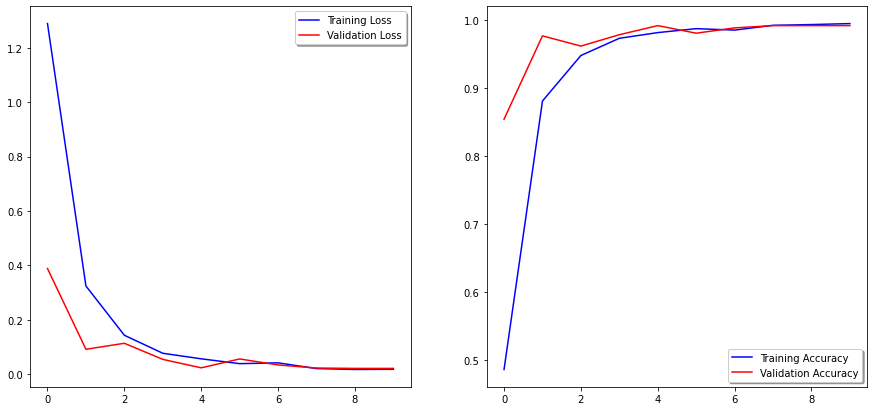

In [39]:
plt.figure(figsize=(15,7))
ax1 = plt.subplot(1,2,1)
ax1.plot(history.history['loss'], color='b', label='Training Loss') 
ax1.plot(history.history['val_loss'], color='r', label = 'Validation Loss',axes=ax1)
legend = ax1.legend(loc='best', shadow=True)
ax2 = plt.subplot(1,2,2)
ax2.plot(history.history['accuracy'], color='b', label='Training Accuracy') 
ax2.plot(history.history['val_accuracy'], color='r', label = 'Validation Accuracy')
legend = ax2.legend(loc='best', shadow=True)


In [43]:
model.save('/content/my_model.h5',save_format='h5')